# Вариант 7
* X1 ~ N(-1, 2), n1 = 100
* X2 ~ R(-2, 0), n2 = 100

In [110]:
import numpy as np
import seaborn as sns
import matplotlib as plt

from scipy import stats as st
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

from typing import Dict, Tuple, List

## 1. Исходные данные

In [3]:
def describe_distribution(distribution, name) -> Dict[str, Dict[str, float]]:
    description = st.describe(distribution)

    return {
            name: {
                      'mean': description[2],
                      'variance': description[3],
                      'deviation': np.sqrt(description[3])
                  }
           }

In [5]:
n1 = 100
x1 = st.distributions.norm(-1, 2).rvs(n1, random_state=42)

n2 = 100
x2 = st.distributions.uniform.rvs(loc=-2, scale=2, size=n2, random_state=42)

n3 = 200
x3 = st.distributions.norm(2, 1).rvs(n3, random_state=42)

In [7]:
describe_distribution(x1, 'X1 ~ N(-1, 2)'), describe_distribution(x2, 'X2 ~ R(-2, 0)'), describe_distribution(x3, 'X3 ~ N(2, 1)')

({'X1 ~ N(-1, 2)': {'mean': -1.2076930347881878,
   'variance': 3.2990795745206403,
   'deviation': 1.8163368560156017}},
 {'X2 ~ R(-2, 0)': {'mean': -1.0596385132435813,
   'variance': 0.3539997986649662,
   'deviation': 0.5949788220306386}},
 {'X3 ~ N(2, 1)': {'mean': 1.9592290348279149,
   'variance': 0.8667682901307653,
   'deviation': 0.9310039152070013}})

In [31]:
list(describe_distribution(x1, '1').values())[0]['mean']

-1.2076930347881878

In [35]:
def pool_distributions(distributions: List[np.array], volumes: List[int]) -> Dict:
    descriptions = [describe_distribution(distribution, str(i)) for i, distribution in enumerate(distributions)]
    total_volume = sum(volumes)

    mean = sum([(volume * list(description.values())[0]['mean']) / total_volume
                for description, volume in zip(descriptions, volumes)])
    variance = sum([((volume - 1) * list(description.values())[0]['variance']) / (total_volume - 3)
                for description, volume in zip(descriptions, volumes)])
    std = np.sqrt(variance)

    return {
            'Pooled': {
                          'mean': mean,
                          'variance': variance,
                          'std': std
                      }
           }

In [37]:
distributions, volumes = [x1, x2, x3], [n1, n2, n3]

pool_distributions(distributions, volumes)

{'Pooled': {'mean': 0.41278163040601523,
  'variance': 1.3454452082654844,
  'std': 1.159933277505859}}

## 2. Boxplots

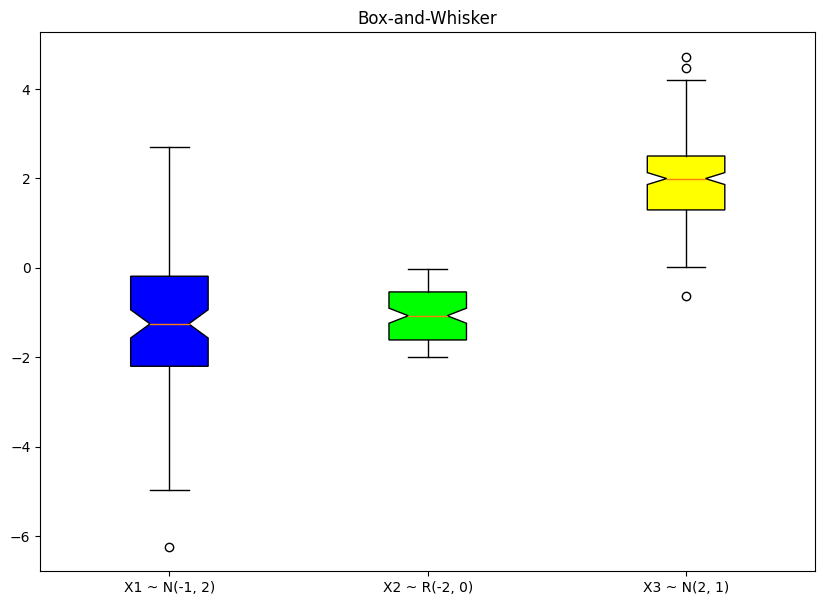

In [47]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = plt.boxplot(distributions, patch_artist = True, notch ='True')

colors = ['#0000FF', '#00FF00', '#FFFF00']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(['X1 ~ N(-1, 2)', 'X2 ~ R(-2, 0)', 'X3 ~ N(2, 1)',])

# Adding title
plt.title("Box-and-Whisker")


plt.show()

## 3. Проверка условий дисперсионного анализа

In [48]:
st.bartlett(x1, x2, x3)

BartlettResult(statistic=130.39676026168988, pvalue=4.838416830013518e-29)

## 4. Однофакторный дисперсионный анализ

In [101]:
K = 3
concated = np.concatenate(distributions)
total_mean = np.mean(concated)
total_variance = np.concatenate(distributions).var()

intragroup = np.sum([len(distribution) * distribution.var() for distribution in distributions]) / concated.shape[0]
intergroup = np.sum([len(distribution) * (distribution.mean() - total_mean) ** 2 for distribution in distributions]) / concated.shape[0]

intragroup_variation_coef = intragroup / (np.sum([len(distribution) * distribution.mean() for distribution in distributions]) / concated.shape[0])
interagroup_variation_coef = intergroup / (np.sum([len(distribution) * distribution.mean() for distribution in distributions]) / concated.shape[0])

### Таблица дисперсионного анализа

In [102]:
intergroup + intragroup, np.concatenate(distributions).var()

(3.7295939615154494, 3.72959396151545)

In [103]:
intragroup_variation_coef, interagroup_variation_coef

(3.2350140385123933, 5.800257123741102)

In [104]:
intragroup, intergroup

(1.3353543692034933, 2.394239592311956)

In [105]:
concated.var() / concated.mean()

9.035271162253494

### Критерий

In [106]:
st.f_oneway(x1, x2, x3)

F_onewayResult(statistic=355.90294983450895, pvalue=2.8582043514361526e-89)

In [107]:
f'Эмперический коэффициент детерминации: {np.round(intergroup / (intergroup + intragroup), 2)}'

'Эмперический коэффициент детерминации: 0.64'

In [108]:
f'Эмперическое корелляционное отношение: {np.round(np.sqrt(intergroup / (intergroup + intragroup)), 2)}'

'Эмперическое корелляционное отношение: 0.8'

## 5. Метод линейных контрастов

In [124]:
groups = np.concatenate((np.repeat(['x1', 'x2'], repeats=n1) ,np.repeat(['x3'], repeats=n3)))

In [127]:
print(pairwise_tukeyhsd(endog=concated, groups=groups, alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
    x1     x2   0.1481 0.639 -0.2379  0.534  False
    x1     x3   3.1669   0.0  2.8327 3.5011   True
    x2     x3   3.0189   0.0  2.6847 3.3531   True
--------------------------------------------------


In [134]:
def linear_contrast_variance(volume, intergroup_var, K, x1, x2) -> float:
    return volume * intergroup_var * (1 / x1.shape[0] + 1 / x2.shape[0]) / (volume - K)

def lower_upper_bounds(diff, lkv, K, volume, alpha=0.05) -> Tuple[float, float]:
    quantile = st.f(K-1,volume-K).ppf(1 - alpha)
    delta = np.sqrt(lkv * (K - 1) * quantile)

    return (diff - delta, diff + delta)


diff12 = x1.mean() - x2.mean()
diff13 = x1.mean() - x3.mean()
diff23 = x2.mean() - x3.mean()

var12 = linear_contrast_variance(concated.shape[0], intergroup, K, x1, x2)
var13 = linear_contrast_variance(concated.shape[0], intergroup, K, x1, x3)
var23 = linear_contrast_variance(concated.shape[0], intergroup, K, x2, x3)

<ipython-input-146-a939ad68179e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(bounds, (i, i), 'ro-', color='b')


([<matplotlib.axis.YTick object at 0x792da78f8dc0>, <matplotlib.axis.YTick object at 0x792da78f8760>, <matplotlib.axis.YTick object at 0x792da7964340>], [Text(0, 0, '1-2'), Text(0, 1, '1-3'), Text(0, 2, '2-3')])


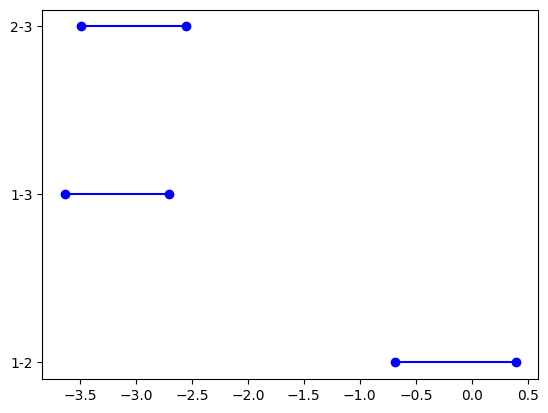

In [146]:
interval_mapper = {0: '1-2', 1: '1-3', 2: '2-3'}
diffs = [diff12, diff13, diff23]
vars = [var12, var13, var23]
pair_bounds = [lower_upper_bounds(diff, lkv, K, concated.shape[0]) for diff, lkv in zip(diffs, vars)]

for i, bounds in enumerate(pair_bounds):
    plt.plot(bounds, (i, i), 'ro-', color='b')

print(plt.yticks(range(len(pair_bounds)), list(interval_mapper.values())))